<a href="https://colab.research.google.com/github/c-walls/Essay-Score-Predictions/blob/main/RandomForest_with_H-ParamTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S R
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

DATA_SOURCE_MAPPING = 'linking-writing-processes-to-writing-quality:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F59291%2F6678907%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T011553Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2cf3263882945d2d403d09c82a02c03f75e99d9dc23517fa32d55d8642dd75b7c15904130575a0d5399c9362095593fc7ee2c632d990a65469101e939d2fd06467312b94a53ccad9541b6d6ebea4976033512121b716d0cde5d566cfb2d3feb0b8dc34494577e76263aaabe6a9cca3d23cb3b1f581f39311e1133a9773b7d4d520ba8af3bd590412f3de5ebb181a3ccf81f7874ed4cbefe5989e3071eeb7841aeeb1a90e480de9bfce9f45553b5c0655051d61c7bde4ade586f5e3633a034d923af63efc8d1b274462fc32db1ed3bf15e477b05c77dac5f3cc1177b1a6aacc96330b31e77bcb4bff862632abd56213e040dc306e9f4a44a03f713bac6afbfd72'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

system(paste0('sudo umount ', '/kaggle/input'))
system(paste0('sudo rmdir ', '/kaggle/input'))
system(paste0('sudo mkdir -p -- ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo ln -sfn ', KAGGLE_INPUT_PATH,' ',file.path('..', 'input')), intern=TRUE)
system(paste0('sudo mkdir -p -- ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo ln -sfn ', KAGGLE_WORKING_PATH, ' ', file.path('..', 'working')), intern=TRUE)

data_source_mappings = strsplit(DATA_SOURCE_MAPPING, ',')[[1]]
for (data_source_mapping in data_source_mappings) {
    path_and_url = strsplit(data_source_mapping, ':')
    directory = path_and_url[[1]][1]
    download_url = URLdecode(path_and_url[[1]][2])
    filename = sub("\\?.+", "", download_url)
    destination_path = file.path(KAGGLE_INPUT_PATH, directory)
    print(paste0('Downloading and uncompressing: ', directory))
    if (endsWith(filename, '.zip')){
      temp = tempfile(fileext = '.zip')
      download.file(download_url, temp)
      unzip(temp, overwrite = TRUE, exdir = destination_path)
      unlink(temp)
    }
    else{
      temp = tempfile(fileext = '.tar')
      download.file(download_url, temp)
      untar(temp, exdir = destination_path)
      unlink(temp)
    }
    print(paste0('Downloaded and uncompressed: ', directory))
}

print(paste0('Data source import complete'))


character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

[1] "Downloading and uncompressing: linking-writing-processes-to-writing-quality"
[1] "Downloaded and uncompressed: linking-writing-processes-to-writing-quality"
[1] "Data source import complete"


In [ ]:
install.packages("moments")
install.packages("caTools")
install.packages("randomForest")
install.packages("caret")

library(moments)
library(ggplot2)
library(caTools)
library(randomForest)
library(readr)
library(caret)

train_scores <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")
train_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
sample_submission <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv")
test_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")
test_scores <- data.frame(id = unique(test_logs$id))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice



# DATA CLEANING

In [ ]:
data_cleaning <- function(logs) {

  #Combine Event Columns
  logs <- logs[, names(logs) != "up_event"]
  names(logs)[names(logs) == "down_event"] <- "event"

  #Simplify Move Activities
  tryCatch ({
      logs[substr(logs$activity, 1, 1) == "M", ]$text_change <- strsplit(logs[substr(logs$activity, 1, 1) == "M", ]$activity, " From ")[[1]][2]
      logs[substr(logs$activity, 1, 1) == "M", ]$activity <- "Move"
  }, error = function(e) {
      cat("Error reformatting MOVE activities:\n", conditionMessage(e), "\n")
  })

  #Remove extra movement info from 'undo' rows & convert to factor
  logs$activity <- as.factor(logs$activity)
  str(logs$activity)


  #Simplify Event Values
  logs$event <- gsub("(?i)(F[0-9]{1,2}|.*Media.*|.*Audio.*|.*Pause.*).*", "DeviceFeatureChangeKey", logs$event)
  logs$event <- gsub("(?i)(Scroll.*|Meta|Dead|Process|OS|AltGraph|Mode.*)", "SpecialProcessKey", logs$event)
  logs$event <- gsub("(?i)(Clear|Cancel)", "Escape", logs$event)
  logs$event <- gsub("^[0-9]$", "DigitKey", logs$event)
  logs$event <- gsub("(?i).*Arrow.*", "ArrowKey", logs$event)
  logs$event <- gsub("(?i)(Home|End|^Page.*)", "TextJumpKey", logs$event)

  #Compile list of allowed event values
  event_labels <- c("^[A-Za-z]$", "^[[:punct:]]$", "click", "Shift", "Space", "Backspace", "Enter", "Tab", "Caps", "Control", "Delete", "Insert", "Escape", "Print", "RareKey", "NumLock", "Alt", "ContextMenu", "ArrowKey", "TextJumpKey", "DeviceFeatureChangeKey", "SpecialProcessKey", "DigitKey", "Unidentified")
  valid_events <- unique(logs$event)[apply(sapply(event_labels, function(x) grepl(x, unique(logs$event))), 1, any)]

  #Replace remaining event values with "Unidentified"
  cat("\n", "\n", "INVALID VALUES: ")
  print(table(logs$event, exclude = valid_events))
  logs$event <- ifelse(logs$event %in% valid_events, logs$event, "Unidentified")

  cat("\n", "RARE VALUES: ")
  print(names(which(table(logs$event) < 25)))
  logs$event[logs$event %in% names(which(table(logs$event) < 25))] <- "RareKey"

  cat("\n", "REMAINING VALUES: ")
  print(unique(logs$event))
  cat("Total 'Event' Values: ", length(unique(logs$event)))

  #Convert event variable to factor and check
  logs$event <- as.factor(logs$event)
  str(logs$event)

  return(logs)
}

train_logs <- data_cleaning(train_logs)

 Factor w/ 6 levels "Input","Move",..: 3 3 3 1 1 1 1 1 1 1 ...

 
 INVALID VALUES: 
       \u0096        \u009b        \u0097        \u0080 â\u0080\u0093 
            2             1            14             1             4 
      Å\u009f             ä            Â´            Ä±       Ë\u0086 
            1             1             1             3             1 

 RARE VALUES:  [1] "_"            "¡"            "¿"            "{"            "}"           
 [6] "@"            "#"            "`"            "^"            "|"           
[11] "~"            "A"            "b"            "C"            "d"           
[16] "e"            "f"            "F"            "g"            "h"           
[21] "i"            "I"            "j"            "l"            "m"           
[26] "M"            "Middleclick"  "n"            "o"            "p"           
[31] "r"            "S"            "t"            "T"            "u"           
[36] "Unknownclick" "V"            "w"            "y"    

# FEATURE ENGINEERING

In [ ]:
create_features <- function(logs, scores) {

  total_events <- function(logs, scores) {
    result <- aggregate(event_id ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "event_id"] <- "total_events"
    return(result)
  }

  event_diversity <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) length(unique(x)))
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "event_diversity"
    return(result)
  }

  normalized_event_diversity <- function(scores) {
    scores$normalized_event_diversity <- scores$event_diversity / scores$total_events
    return(scores)
  }

  submitted_words <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = function(x) tail(x, 1))
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "submitted_words"
    return(result)
  }

  submission_complexity <- function(scores) {
    scores$submission_complexity <- scores$submitted_words / scores$total_events
    return(scores)
  }

  max_words <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "max_words"
    return(result)
  }

  word_reduction <- function(scores) {
    scores$word_reduction <- scores$max_words - scores$submitted_words
    return(scores)
  }

  word_count_mean <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = mean)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_mean"
    return(result)
  }

  word_count_sd <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = sd)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_sd"
    return(result)
  }

  word_count_skew <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = skewness)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_skew"
    return(result)
  }

  word_count_kurt <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = kurtosis)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_kurt"
    return(result)
  }

  word_count_median <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = median)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_median"
    return(result)
  }

  word_count_IQR <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = IQR)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_IQR"
    return(result)
  }

  submission_time <- function(logs, scores) {
    result <- aggregate(up_time ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "up_time"] <- "submission_time"
    return(result)
  }

  first_input <- function(logs, scores) {
    result <- aggregate(down_time ~ id, data = logs[logs$activity == "Input", ], FUN = min)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "down_time"] <- "first_input"
    return(result)
  }

  writing_time <- function(scores) {
    scores$writing_time <- scores$submission_time - scores$first_input
    return(scores)
  }

  submit_word_rate <- function(scores) {
    scores$submit_word_rate <- scores$submitted_words / scores$writing_time
    return(scores)
  }

  max_word_rate <- function(scores) {
    scores$max_word_rate <- scores$max_words / scores$writing_time
    return(scores)
  }

  normalized_cursor_position <- function(logs, scores) {
    logs <- merge(scores[ , c("id", "submitted_words")], logs, by = "id", all.x = TRUE)
    logs$normalized_cursor_position <- logs$cursor_position / logs$submitted_words
    return(logs)
  }

  cursor_position_mean <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = mean)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_mean"
    return(result)
  }

  cursor_position_sd <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = sd)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_sd"
    return(result)
  }

  cursor_position_skew <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = skewness)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_skew"
    return(result)
  }

  cursor_position_kurt <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = kurtosis)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_kurt"
    return(result)
  }

  cursor_position_median <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = median)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_median"
    return(result)
  }

  cursor_position_IQR <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = IQR)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_IQR"
    return(result)
  }

  cursor_position_max <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_max"
    return(result)
  }

  word_reduction <- function(scores) {
    scores$word_reduction <- scores$max_words - scores$submitted_words
    return(scores)
  }

  input_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Input"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "input_count"
    return(result)
  }

  cut_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Remove/Cut"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "cut_count"
    return(result)
  }

  paste_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Paste"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "paste_count"
    return(result)
  }

  move_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Move"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "move_count"
    return(result)
  }

  replace_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Replace"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "replace_count"
    return(result)
  }

  nonproduction_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Nonproduction"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "nonproduction_count"
    return(result)
  }

  input_frequency <- function(scores) {
    scores$input_frequency <- scores$input_count / scores$total_events
    return(scores)
  }

  nonproduction_frequency <- function(scores) {
    scores$nonproduction_frequency <- scores$nonproduction_count / scores$total_events
    return(scores)
  }

  cut_frequency <- function(scores) {
    scores$cut_frequency <- scores$cut_count / scores$total_events
    return(scores)
  }

  cut_input_ratio <- function(scores) {
    scores$cut_input_ratio <- scores$cut_count / scores$input_count
    return(scores)
  }

  input_rate <- function(scores) {
    scores$input_rate <- scores$input_count / scores$writing_time
    return(scores)
  }

  input_productivity <- function(scores) {
    scores$input_productivity <- scores$input_count / scores$submitted_words
    return(scores)
  }

  period_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "."))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "period_count"
    return(result)
  }

  comma_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == ","))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "comma_count"
    return(result)
  }

  punctuation_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "." | x == "," | x == "!" | x == "?" | x == ":" | x == ";"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "punctuation_count"
    return(result)
  }

  space_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Space"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "space_count"
    return(result)
  }

  enter_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Enter"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "enter_count"
    return(result)
  }

  deletion_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Delete" | x == "Backspace" | x == "c"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "deletion_count"
    return(result)
  }

  shift_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Shift"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "shift_count"
    return(result)
  }

  tab_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Tab"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "tab_count"
    return(result)
  }

  punctuation_frequency <- function(scores) {
    scores$punctuation_frequency <- scores$punctuation_count / scores$submitted_words
    return(scores)
  }

  deletion_frequency <- function(scores) {
    scores$deletion_frequency <- scores$deletion_count / scores$submitted_words
    return(scores)
  }

  shift_frequency <- function(scores) {
    scores$shift_frequency <- scores$shift_count / scores$submitted_words
    return(scores)
  }

  tab_frequency <- function(scores) {
    scores$tab_frequency <- scores$tab_count / scores$submitted_words
    return(scores)
  }

  enter_frequency <- function(scores) {
    scores$enter_frequency <- scores$enter_count / scores$submitted_words
    return(scores)
  }

  period_frequency <- function(scores) {
    scores$period_frequency <- scores$period_count / scores$submitted_words
    return(scores)
  }

  comma_frequency <- function(scores) {
    scores$comma_frequency <- scores$comma_count / scores$submitted_words
    return(scores)
  }

  space_frequency <- function(scores) {
    scores$space_frequency <- scores$space_count / scores$submitted_words
    return(scores)
  }

  scores <- total_events(logs, scores)
  scores <- event_diversity(logs, scores)
  scores <- normalized_event_diversity(scores)
  scores <- submitted_words(logs, scores)
  scores <- submission_complexity(scores)
  scores <- max_words(logs, scores)
  scores <- word_reduction(scores)
  scores <- word_count_mean(logs, scores)
  scores <- word_count_sd(logs, scores)
  scores <- word_count_median(logs, scores)
  scores <- word_count_IQR(logs, scores)
  scores <- word_count_skew(logs, scores)
  scores <- word_count_kurt(logs, scores)
  scores <- submission_time(logs, scores)
  scores <- first_input(logs, scores)
  scores <- writing_time(scores)
  scores <- submit_word_rate(scores)
  scores <- max_word_rate(scores)
  logs <- normalized_cursor_position(logs, scores)
  scores <- cursor_position_mean(logs, scores)
  scores <- cursor_position_sd(logs, scores)
  scores <- cursor_position_median(logs, scores)
  scores <- cursor_position_IQR(logs, scores)
  scores <- cursor_position_skew(logs, scores)
  scores <- cursor_position_kurt(logs, scores)
  scores <- cursor_position_max(logs, scores)
  scores <- input_count(logs, scores)
  scores <- cut_count(logs, scores)
  scores <- paste_count(logs, scores)
  scores <- move_count(logs, scores)
  scores <- nonproduction_count(logs, scores)
  scores <- replace_count(logs, scores)
  scores <- input_frequency(scores)
  scores <- nonproduction_frequency(scores)
  scores <- cut_frequency(scores)
  scores <- cut_input_ratio(scores)
  scores <- input_rate(scores)
  scores <- input_productivity(scores)
  scores <- period_count(logs, scores)
  scores <- comma_count(logs, scores)
  scores <- punctuation_count(logs, scores)
  scores <- space_count(logs, scores)
  scores <- enter_count(logs, scores)
  scores <- deletion_count(logs, scores)
  scores <- shift_count(logs, scores)
  scores <- tab_count(logs, scores)
  scores <- punctuation_frequency(scores)
  scores <- deletion_frequency(scores)
  scores <- shift_frequency(scores)
  scores <- tab_frequency(scores)
  scores <- enter_frequency(scores)
  scores <- period_frequency(scores)
  scores <- comma_frequency(scores)
  scores <- space_frequency(scores)

  return(scores)
}

train_scores <- create_features(train_logs, train_scores)

cat("\n", "LOG VARIABLES:", "\n")
print(names(train_logs))
cat("\n", "\n", "SCORE VARIABLES:", "\n")
print(names(train_scores))


 LOG VARIABLES: 
 [1] "id"              "event_id"        "down_time"       "up_time"        
 [5] "action_time"     "activity"        "event"           "text_change"    
 [9] "cursor_position" "word_count"     

 
 SCORE VARIABLES: 
 [1] "id"                         "cursor_position_max"       
 [3] "cursor_position_kurt"       "cursor_position_skew"      
 [5] "cursor_position_IQR"        "cursor_position_median"    
 [7] "cursor_position_sd"         "cursor_position_mean"      
 [9] "first_input"                "submission_time"           
[11] "word_count_kurt"            "word_count_skew"           
[13] "word_count_IQR"             "word_count_median"         
[15] "word_count_sd"              "word_count_mean"           
[17] "max_words"                  "submitted_words"           
[19] "event_diversity"            "total_events"              
[21] "score"                      "normalized_event_diversity"
[23] "submission_complexity"      "word_reduction"            
[25] "wri

# PREDICTIVE MODELING

[1] 2463 2227  526  195 1842 1142 1253 1268 1038  665 1627 1011 1115  953
  [15]  348 1017 2013 1379 2074 1450 1673 1790  211 1614  555 1895  373 1167
  [29] 1799  905 1866 1047  309 1248  166  217 1314 2120  588 1599  141  722
  [43]  153  294  277 1487   41 2138  316 1183  752  374 2467 2033 2082  516
  [57]   13 2117 2038 1919  755 1332 1113 1006 2339 1448  671 2169 1134 1088
  [71] 1507 1934 1501  480 2115 1914 1871 1109  165 1075 1386 2284  610 2378
  [85]  127 2260  686 1982  931 2291  847  983  619 1927  477 1999  151 1638
  [99] 2208 2203 1029  326 1956 1262 1788 1363  985 2087  986  137 1762 1584
 [113]  589 1903 2364 2244 1793  680 1630 2365 1808  344 2468 1885  876 2225
 [127]  554 2132 1547 1326  706  712 1452  672 1274 1828  528 1569 2088 1960
 [141]  473 2248 2002 1149 2037 2313 2388 2234  458  831 1078  919 1562 2283
 [155] 1313  185  413  627 1333 2253 1899  779 1561  564  794 1415 1370  160
 [169]  617  357  279  270 2266  618 1905  337 2453  539  981  956 1781 1690
 [183] 1522 1445 1081 2211 1697 1413  117  648 1079 1241 1706  873  757 1965
 [197]  988  711 1492 1234  349 1425 2346  386 1165 2072 1987 1154 2213 1727
 [211] 1612 1401 2218 1469  710 1258 2112 2128 2401 1347  791 2265 2442 1341
 [225]  807 1246 1311 1758  292 1250 1814 1708  297  860  605 1835 1261 2263
 [239] 2379 1057   83  866 1023   76 1118 2163 2386 1382  682 2406 2319  989
 [253] 1961 1738 1471 1362  243 2154 2059  625 2268  461 2431   31 1950 1139
 [267] 2241   94   16  178 1436  524 1461  924 1602  204 1146  259  494 1889
 [281] 1784 2317 1355 1132 1325   10  170 1233 1851 2451  108    8  626  261
 [295] 1098 1609 1911 1286 1760 2196 1747 1243  667  990 1143  452  856 1948
 [309] 1603 2332  646 1060 1264  891 1656 1886 1328 2462 2035 1636  793 1412
 [323] 1204  278  241   24 2262 2085 1327 1743 2067 1695  378  549 1639 2464
 [337] 2096  393 1395  670 1213  311 1442 1406 2086 1108  319 1862 1666  120
 [351] 1557  599 1339 2281  134  424 2054  879  668 1824   49 1500  193  303
 [365]  191 1651  817 1446 1316 1397 1559 1624  950 1437  698 1787 1227  758
 [379]  993 1464  251  643 2168 1346 2214 1517 2222  445   95  379 1366  620
 [393]  448  242 1992  407 1498 1465  218 2282   79 1531  579 1831  422  493
 [407]  730 1820 2434  877 1065  904  848  450 1256 1358 1864 2425  201   52
 [421] 1249 2354  577  457 1015 2325 1997 1565 1044 1230  124  592 2443  740
 [435]   45 1356 1305   91  653 2004 1162  606 2387 1449 1804 1032  839 1295
 [449]  595 1969  747 1191  499 1279 2063 1658 2383  902   71 1796 1994   81
 [463] 1968  776 2199 2226 2347  896 2007 1774  997 2300 2201 1670 2362  673
 [477]  628 1070   64  531  229 1634 1153 1244 1716 2246  836 2070  602 2195
 [491]  331  901  502 1508 1811  291 1953  743 1733  829 2320 1193  729 2217
 [505] 1585 1365   69 1344  504 1100 1026  886  786 2012 1130 1135  855 2420
 [519] 1096  449  888  971 2465 2343 2142  335 2458 1080 2298  271  207  436
 [533] 2005 1001  601 2103  387 1287 1092 1144  744  565 1381  792  742 1985
 [547] 1859  523  586  256 1373 1495 1980   88 1440 1881   11 1923  463 1779
 [561]  700 2245  842  685 2183  280 1536  803 2078  778 2402 1352  172 1322
 [575] 2304 1703 1702 1553  468 1408  929  741  365  591 1920 1251  834 2124
 [589] 1646 2119 2215 1289  535 2151  982  112  456 1117 1513  789  631   48
 [603]  969  482 1272  105 1195  696  459 2416 2025 1336 1586  892  139 1782
 [617]  481  843 1852  250 1766 1621  330  633 1650 2349 1123 1122 1082 2144
 [631] 2275 1549 2180  258  635  262 2017 1894  928  206  199 1613 1863 2256
 [645] 1834 2118 1555  753 1512 2024  398 1242 1179 2184 2334  818 1959  660
 [659]  347 2177 1589 1353 2405 2366   55 1271 1394 1554 1939 1068 2238 2121
 [673] 2044 1400  932 2126 1879 1578 1973  194 1618  460  576 1101 1643 1715
 [687]  998 1682 1290  713  355  470  339  200 2235 2093 1838 1404  893  766
 [701] 1136 2371  469  479  612 1435 1431 1679  746 2137 1843 2306  290 1910
 [715]  466 2027  488  814 1880 1888 1671 1502  321    9  867  281  642  907

mtry = 18  OOB error = 0.448445 
Searching left ...
mtry = 6 	OOB error = 0.4512646 
-0.006287415 0.01 
Searching right ...
mtry = 54 	OOB error = 0.4498175 
-0.003060648 0.01 

Call:
 randomForest(x = train[, names(train) != "score"], y = train$score,      ntree = 500, mtry = best.m, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 18

          Mean of squared residuals: 0.448042
                    % Var explained: 56.83


     y_pred
      1.64461666666667 1.68635 1.69155 1.7514 1.78381666666667 1.80946666666667
  0.5                0       0       0      0                0                0
  1                  0       0       1      1                0                1
  1.5                1       0       0      0                0                0
  2                  0       1       0      0                0                0
  2.5                0       0       0      0                0                0
  3                  0       0       0      0                1                0
  3.5                0       0       0      0                0                0
  4                  0       0       0      0                0                0
  4.5                0       0       0      0                0                0
  5                  0       0       0      0                0                0
  5.5                0       0       0      0                0                0
  6                  0      

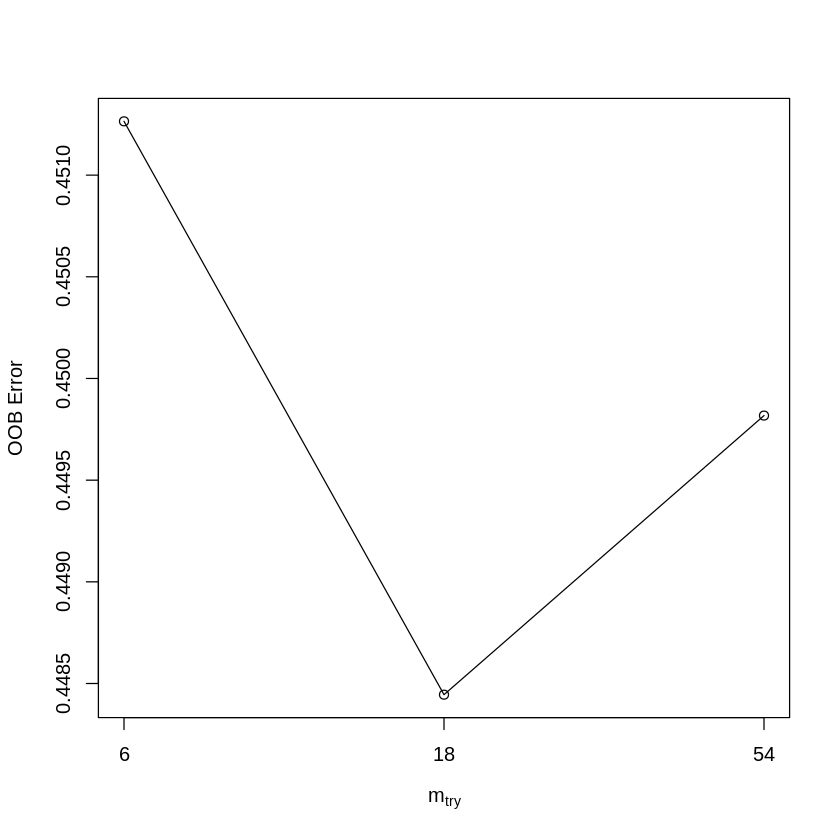

,%IncMSE,IncNodePurity
id,0.3987182,19.2281186
cursor_position_max,18.4790831,270.1408799
cursor_position_kurt,0.3875227,13.8108114
cursor_position_skew,3.2673285,14.8842625
cursor_position_IQR,8.5577885,19.3606040
cursor_position_median,10.7878911,21.1802719
cursor_position_sd,10.8533464,123.5711409
cursor_position_mean,9.9522422,55.9592458
first_input,4.4074172,23.0081303
submission_time,1.7491109,14.9889038


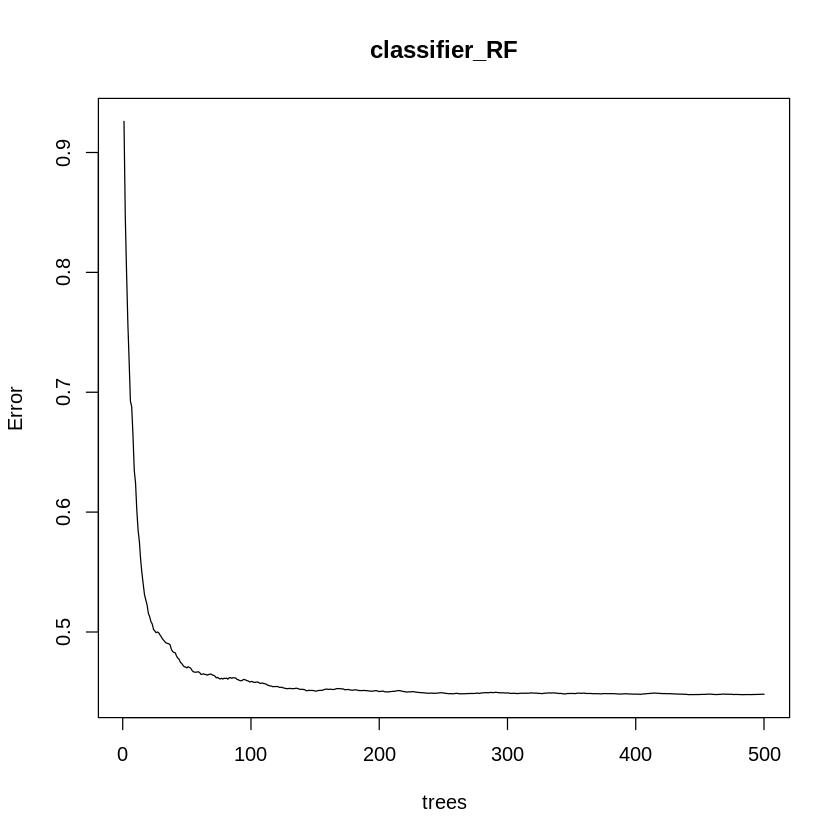

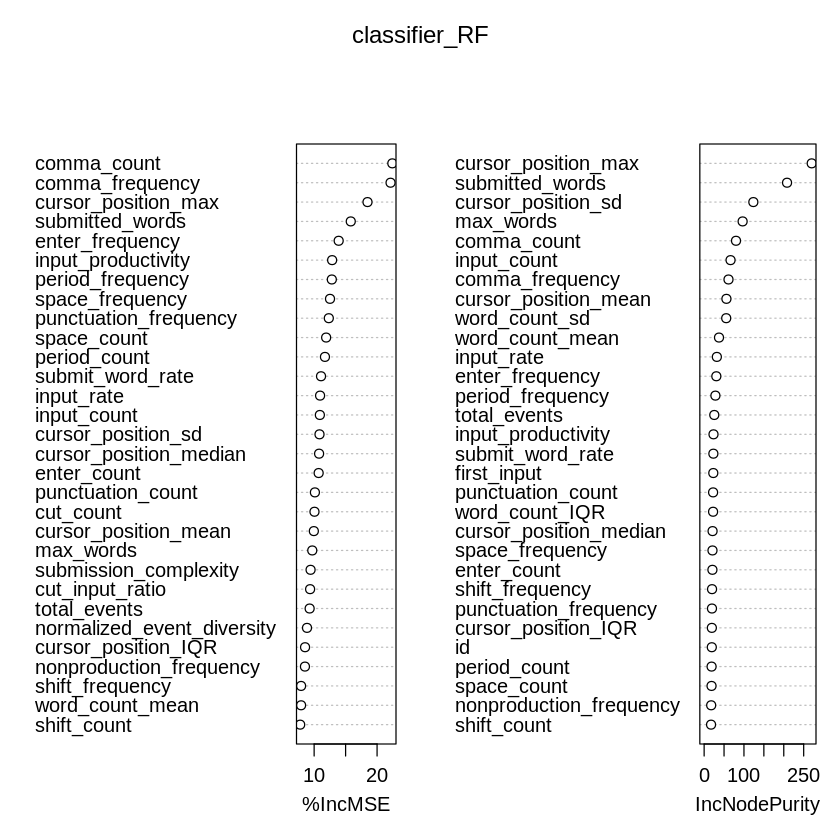

In [ ]:
# Splitting data into train and test data
set.seed(123)
split_indices <- sample(1:nrow(train_scores), size = 0.7 * nrow(train_scores))
split_indices

train <- train_scores[split_indices, ]
test <- train_scores[-split_indices, ]


# Hyper Parameter Tuning
mtry <- tuneRF(train[, names(train) != "score"],
               train$score,
               ntreeTry = 500,
               stepFactor = 3,
               improve = 0.01,
               trace = TRUE,
               plot = TRUE
)
best.m <- mtry[mtry[, 2] == min(mtry[, 2]), 1]

classifier_RF = randomForest(x = train[, names(train) != "score"],
                             y = train$score,
                             mtry = best.m,
                             importance = TRUE,
                             ntree = 500
                            )

# View the tuned parameters
print(classifier_RF)

# Predicting the Test set results
y_pred = predict(classifier_RF, newdata = test[, names(train) != "score"])

# Confusion Matrix
confusion_mtx = table(test[, names(train) == "score"], y_pred)
confusion_mtx

# Plotting model
plot(classifier_RF)

# Importance plot
importance(classifier_RF)

# Variable importance plot
varImpPlot(classifier_RF)

# PREPPING TEST SET

In [ ]:
test_logs <- data_cleaning(test_logs)
test_scores <- create_features(test_logs, test_scores)

cat("\n", "\n", "TRAIN_SCORES VARIABLES:", "\n")
print(names(train_scores))

cat("\n", "\n", "TEST_SCORES VARIABLES:", "\n")
print(names(test_scores))

print(classifier_RF)

test_scores[test_scores == "NaN"] <- 0
test_scores[test_scores == "Inf"] <- 0
test_scores[is.na(test_scores)] <- 0

Error reformatting MOVE activities:
 subscript out of bounds 
 Factor w/ 1 level "Input": 1 1 1 1 1 1

 
 INVALID VALUES: < table of extent 0 >

 RARE VALUES: [1] "q"     "Space"

 REMAINING VALUES: [1] "RareKey"
Total 'Event' Values:  1 Factor w/ 1 level "RareKey": 1 1 1 1 1 1

 
 TRAIN_SCORES VARIABLES: 
 [1] "id"                         "cursor_position_max"       
 [3] "cursor_position_kurt"       "cursor_position_skew"      
 [5] "cursor_position_IQR"        "cursor_position_median"    
 [7] "cursor_position_sd"         "cursor_position_mean"      
 [9] "first_input"                "submission_time"           
[11] "word_count_kurt"            "word_count_skew"           
[13] "word_count_IQR"             "word_count_median"         
[15] "word_count_sd"              "word_count_mean"           
[17] "max_words"                  "submitted_words"           
[19] "event_diversity"            "total_events"              
[21] "score"                      "normalized_event_diversity"

# MAKE PREDICTIONS

In [ ]:
test_predictions <- predict(classifier_RF, newdata = test_scores)
sample_submission <- data.frame(id = test_scores$id, score = test_predictions)
write_csv(sample_submission, "submission.csv")